##Performance Comparison
This Notebook includes producing results from Experiment 1 and Assessment 1

First, we will import all the relevant packages

In [0]:
import time
from multiprocessing import Pool
from functools import partial
from collections import Counter, defaultdict
from typing import Dict, Iterable, FrozenSet, Set, Tuple
import matplotlib.pyplot as plt
from prov.model import ProvDocument, ProvElement, ProvRecord, QualifiedName
from prov.constants import (
    PROV_ENTITY,
    PROV_ACTIVITY,
    PROV_GENERATION,
    PROV_USAGE,
    PROV_COMMUNICATION,
    PROV_START,
    PROV_END,
    PROV_INVALIDATION,
    PROV_DERIVATION,
    PROV_AGENT,
    PROV_ATTRIBUTION,
    PROV_ASSOCIATION,
    PROV_DELEGATION,
    PROV_INFLUENCE,
    PROV_ALTERNATE,
    PROV_SPECIALIZATION,
    PROV_MENTION,
    PROV_MEMBERSHIP,
)
from pyspark.sql import DataFrame
from prov.model import (
    ProvDocument,
    ProvRecord,
    ProvElement,
    ProvEntity,
    ProvActivity,
    ProvAgent,
    ProvRelation,
    PROV_ATTR_ENTITY,
    PROV_ATTR_ACTIVITY,
    PROV_ATTR_AGENT,
    PROV_ATTR_TRIGGER,
    PROV_ATTR_GENERATED_ENTITY,
    PROV_ATTR_USED_ENTITY,
    PROV_ATTR_DELEGATE,
    PROV_ATTR_RESPONSIBLE,
    PROV_ATTR_SPECIFIC_ENTITY,
    PROV_ATTR_GENERAL_ENTITY,
    PROV_ATTR_ALTERNATE1,
    PROV_ATTR_ALTERNATE2,
    PROV_ATTR_COLLECTION,
    PROV_ATTR_INFORMED,
    PROV_ATTR_INFORMANT,
    PROV_ATTR_BUNDLE,
    PROV_ATTR_PLAN,
    PROV_ATTR_ENDER,
    PROV_ATTR_STARTER,
    ProvBundle,
)
INFERRED_ELEMENT_CLASS = {
    PROV_ATTR_ENTITY: ProvEntity,
    PROV_ATTR_ACTIVITY: ProvActivity,
    PROV_ATTR_AGENT: ProvAgent,
    PROV_ATTR_TRIGGER: ProvEntity,
    PROV_ATTR_GENERATED_ENTITY: ProvEntity,
    PROV_ATTR_USED_ENTITY: ProvEntity,
    PROV_ATTR_DELEGATE: ProvAgent,
    PROV_ATTR_RESPONSIBLE: ProvAgent,
    PROV_ATTR_SPECIFIC_ENTITY: ProvEntity,
    PROV_ATTR_GENERAL_ENTITY: ProvEntity,
    PROV_ATTR_ALTERNATE1: ProvEntity,
    PROV_ATTR_ALTERNATE2: ProvEntity,
    PROV_ATTR_COLLECTION: ProvEntity,
    PROV_ATTR_INFORMED: ProvActivity,
    PROV_ATTR_INFORMANT: ProvActivity,
    PROV_ATTR_BUNDLE: ProvBundle,
    PROV_ATTR_PLAN: ProvEntity,
    PROV_ATTR_ENDER: ProvEntity,
    PROV_ATTR_STARTER: ProvEntity,
}

import functools


from graphframes import *

import requests
from pyspark.sql import DataFrame
import json
import os
from pyspark.sql.functions import col, lit, when
from pyspark.sql.types import IntegerType
from functools import reduce
def download_prov_json_document(url: str) -> ProvDocument:
    # try to download the provided url
    r = requests.get(url)
    r.raise_for_status()

    # no exception so far, we have successfuly downloaded it
    prov_doc = ProvDocument.deserialize(content=r.text)
    return prov_doc
document = download_prov_json_document("https://openprovenance.org/store/documents/4141.json")
document2 = download_prov_json_document("https://openprovenance.org/store/documents/282.json")

To compare the performance on this notebook, we copy-pasted the function from both of the pair-matching and motif finding demo notebooks, and the type counting method from the original development of provenance kernel:  https://github.com/trungdong/provenance-kernel-evaluation/tree/master/scripts

In [0]:
def PKv1(prov_doc, num):
    """All code in this nested function is copy-pasted from https://github.com/trungdong/provenance-kernel-evaluation"""
    """It is only used for performance comparison only"""
    """Professor Trung Dong Huynh's code."""
    SHORT_NAMES = {
        PROV_ENTITY: "ent",
        PROV_ACTIVITY: "act",
        PROV_GENERATION: "gen",
        PROV_USAGE: "usd",
        PROV_COMMUNICATION: "wib",
        PROV_START: "wsb",
        PROV_END: "web",
        PROV_INVALIDATION: "inv",
        PROV_DERIVATION: "der",
        PROV_AGENT: "agt",
        PROV_ATTRIBUTION: "att",
        PROV_ASSOCIATION: "waw",
        PROV_DELEGATION: "del",
        PROV_INFLUENCE: "inf",
        PROV_ALTERNATE: "alt",
        PROV_SPECIALIZATION: "spe",
        PROV_MENTION: "men",
        PROV_MEMBERSHIP: "mem",
    }

    Fingerprint = FrozenSet[QualifiedName]
    FlatProvenanceType = Tuple[Fingerprint, ...]
    MultiLevelTypeDict = Dict[int, Dict[QualifiedName, FlatProvenanceType]]

    def get_element_types(
            element: ProvElement, including_additional_types: bool = True
    ) -> Set[QualifiedName]:
        types = {element.get_type()}
        if including_additional_types:
            types.update(
                {t for t in element.get_asserted_types() if isinstance(t, QualifiedName)}
            )
        return types

    def join_flat_types(
            t1: FlatProvenanceType, t2: FlatProvenanceType
    ) -> FlatProvenanceType:
        if t1 is None:
            return t2
        if t2 is None:
            return t1
        assert len(t1) == len(t2)
        return tuple(f1 | f2 for f1, f2 in zip(t1, t2))

    def format_fingerprint(f: Fingerprint) -> str:
        try:
            types = sorted(SHORT_NAMES[qn] for qn in f)
        except KeyError:
            # only happen with fingerprint_0 containing additional types
            types = sorted([SHORT_NAMES[qn] for qn in f if qn in SHORT_NAMES])
            additional_types = sorted([str(qn) for qn in f if qn not in SHORT_NAMES])
            types.extend(additional_types)
        return "[" + "|".join(types) + "]"

    def print_flat_type(t: FlatProvenanceType) -> str:
        return "→".join(map(format_fingerprint, reversed(t)))

    def count_fp_types(types: Iterable[FlatProvenanceType]) -> Dict[str, int]:
        counter = Counter(types)
        return {print_flat_type(t): count for t, count in counter.items()}

    def calculate_flat_provenance_types(
            prov_doc: ProvDocument, to_level: int = 0, including_primitives_types: bool = True
    ) -> MultiLevelTypeDict:
        # flatten all the bundles, if any
        prov_doc = prov_doc.flattened()

        # initialise index structures
        level0_types = defaultdict(set)  # type: Dict[QualifiedName, Set[QualifiedName]]
        predecessors = defaultdict(
            set
        )  # type: Dict[QualifiedName, Set[Tuple[QualifiedName, QualifiedName]]]

        # indexing node types and relations
        for rec in prov_doc.get_records():  # type: ProvRecord
            if rec.is_element():
                level0_types[rec.identifier] |= get_element_types(
                    rec, including_primitives_types
                )
            elif rec.is_relation():
                rel_type = rec.get_type()
                attrs, values = zip(*rec.formal_attributes)
                # expecting a QualifiedName from the first argument of a relation
                predecessor, successor = values[:2]
                if predecessor is not None and successor is not None:
                    predecessors[successor].add((rel_type, predecessor))

        # the type map for this graph
        fp_types = defaultdict(dict)  # type: MultiLevelTypeDict
        # converting type sets to FlatProvenanceType level 0
        fp_types[0] = {node: (frozenset(level0_types[node]),) for node in level0_types}
        # propagating level-0 types to the specified level
        for k in range(1, to_level + 1):
            # only propagating (k-1) types from nodes that have them
            for node, types in fp_types[k - 1].items():
                # propagating the types to the predecessors
                for rel_type, predecessor in predecessors[node]:
                    k_type = types + (frozenset({rel_type}),)  # type: FlatProvenanceType
                    fp_types[k][predecessor] = (
                        join_flat_types(fp_types[k][predecessor], k_type)
                        if predecessor in fp_types[k]
                        else k_type
                    )

        return fp_types

    fptypes = calculate_flat_provenance_types(
        prov_doc,  # the ProvDocument object to produce types from
        to_level=num,  # calculate types up to this given level (2)
        including_primitives_types=False,  # only consider PROV generic types, ignoring application-specific types
    )
    return fptypes

In [0]:
def PKv2Motif(document,num):
  SHORT_NAMES = {
      "prov:Entity": "ent",
      "prov:Activity": "act",
      "prov:Generation": "gen",
      "prov:Usage": "use",
      "prov:Communication": "wifb",
      "prov:Start": "wsb",
      "prov:End": "web",
      "prov:Invalidation": "wib",
      "prov:Derivation": "der",
      "prov:Agent": "agt",
      "prov:Attribution": "wat",
      "prov:Association": "waw",
      "prov:Delegation": "del",
      "prov:Influence": "inf",
      "prov:Alternate": "alt",
      "prov:Specialization": "spe",
      "prov:Mention": "men",
      "prov:Membership": "mem",
  }
  provClassList = [
      "prov:Entity",
      "prov:Activity",
      "prov:Generation",
      "prov:Usage",
      "prov:Communication",
      "prov:Start",
      "prov:End",
      "prov:Invalidation",
      "prov_Derivation",
      "prov:Agent",
      "prov:Attribution",
      "prov:Association",
      "prov:Delegation",
      "prov:Influence",
      "prov:Alternate",
      "prov:Specialization",
      "prov:Mention",
      "prov:Membership",
  ]
  def prov_to_graphframe(prov_document,primitive):
        unified = prov_document.unified()
        node_map = {}
        vList = []
        eList = []
        if primitive:
          for element in unified.get_records(ProvElement):
            vList.append(((str(element)),str(element.identifier),"$".join([SHORT_NAMES[str(element.get_type())],str(element.get_asserted_types())])))
            node_map[element.identifier] = element
        else:
          for element in unified.get_records(ProvElement):
            vList.append(((str(element)),str(element.identifier),SHORT_NAMES[str(element.get_type())]))
            node_map[element.identifier] = element

        for relation in unified.get_records(ProvRelation):
                # taking the first two elements of a relation
                attr_pair_1, attr_pair_2 = relation.formal_attributes[:2]
                # only need the QualifiedName (i.e. the value of the attribute)
                qn1, qn2 = attr_pair_1[1], attr_pair_2[1]
                if qn1 and qn2:  # only proceed if both ends of the relation exist
                    try:
                        if qn1 not in node_map:
                            node_map[qn1] = INFERRED_ELEMENT_CLASS[attr_pair_1[0]](None, qn1)
                        if qn2 not in node_map:
                            node_map[qn2] = INFERRED_ELEMENT_CLASS[attr_pair_2[0]](None, qn2)
                    except KeyError:
                        # Unsupported attribute; cannot infer the type of the element
                        continue  # skipping this relation
                    eList.append((str(node_map[qn1].identifier), str(node_map[qn2].identifier),SHORT_NAMES[str(relation.get_type())]))
        v = sqlContext.createDataFrame(vList,["element","id","type"])
        e = sqlContext.createDataFrame(eList, ["src","dst","relation_type"])
        g= GraphFrame(v, e) 
        return g
  def formatter(typeDict,lvl):
    for key,value in typeDict.items():
      fullType = []
      for i in range(lvl+1):
        variety = []
        for v in value:
          if v[i] not in variety:
            variety.append(v[i])

        fullType.append("[" + "|".join(variety) + "]")
      typeDict[key] = "→".join(fullType)
    return typeDict
  def typeZero(g):
    typeList = [x["type"]for x in g.vertices.rdd.collect()]
    return typeList
  def typeOne(g):
    motif = g.find("(a)-[e1]->(b);!(b)-[]->(a)")
    edgesList = [[x["e1"],x["a"]]for x in motif.rdd.collect()]
    typeDict = dict((e[1].id,[]) for e in edgesList)
    for e in edgesList:
      zeroType=g.vertices.filter(col("id")==e[0].dst)
      generic = [x["type"]for x in zeroType.rdd.collect()][0]
      fullType = [e[0].relation_type,generic]
      temp = typeDict[e[1].id]
      temp.append(fullType)
      typeDict[e[1].id] = temp
    return typeDict
  def typeTwo(g):
    motif = g.find("(a)-[e1]->(b); (b)-[e2]->(c);!(b)-[]->(a);!(c)-[]->(b)").filter("a.id != c.id")
    edgesList = [[x["e1"],x["e2"],x["a"]]for x in motif.rdd.collect()]
    typeDict = dict((e[2].id,[]) for e in edgesList)
    for e in edgesList:
      zeroType=g.vertices.filter(col("id")==e[1].dst)
      generic = [x["type"]for x in zeroType.rdd.collect()][0]
      fullType = [e[0].relation_type,e[1].relation_type,generic]
      temp = typeDict[e[2].id]
      temp.append(fullType)
      typeDict[e[2].id] = temp
    return typeDict
  def typeThree(g):
    motif = g.find("(a)-[e1]->(b); (b)-[e2]->(c);(c)-[e3]->(d);!(b)-[]->(a);!(c)-[]->(b);!(d)-[]->(c)")
    edgesList = [[x["e1"],x["e2"],x["e3"],x["a"]]for x in motif.rdd.collect()]
    typeDict = dict((e[3].id,[]) for e in edgesList)
    for e in edgesList:
      zeroType=g.vertices.filter(col("id")==e[2].dst)
      generic = [x["type"]for x in zeroType.rdd.collect()][0]
      fullType = [e[0].relation_type,e[1].relation_type,e[2].relation_type,generic]
      temp = typeDict[e[3].id]
      temp.append(fullType)
      typeDict[e[3].id] = temp
    return typeDict
  def typeFour(g):
    motif = g.find("(a)-[e1]->(b); (b)-[e2]->(c);(c)-[e3]->(d);(d)-[e4]->(E);!(b)-[]->(a);!(c)-[]->(b);!(d)-[]->(c);!(E)-[]->(d)")
    edgesList = [[x["e1"],x["e2"],x["e3"],x["e4"],x["a"]]for x in motif.rdd.collect()]
    typeDict = dict((e[4].id,[]) for e in edgesList)
    for e in edgesList:
      zeroType=g.vertices.filter(col("id")==e[3].dst)
      generic = [x["type"]for x in zeroType.rdd.collect()][0]
      fullType = [e[0].relation_type,e[1].relation_type,e[2].relation_type,e[3].relation_type,generic]
      temp = typeDict[e[4].id]
      temp.append(fullType)
      typeDict[e[4].id] = temp
    return typeDict
  def typeFive(g):
    motif = g.find("(a)-[e1]->(b); (b)-[e2]->(c);(c)-[e3]->(d);(d)-[e4]->(E);(E)-[e5]->(f);!(b)-[]->(a);!(c)-[]->(b);!(d)-[]->(c);!(E)-[]->(d);!(f)-[]->(E)")
    edgesList = [[x["e1"],x["e2"],x["e3"],x["e4"],x["e5"],x["a"]]for x in motif.rdd.collect()]
    typeDict = dict((e[5].id,[]) for e in edgesList)
    for e in edgesList:
      zeroType=g.vertices.filter(col("id")==e[4].dst)
      generic = [x["type"]for x in zeroType.rdd.collect()][0]
      fullType = [e[0].relation_type,e[1].relation_type,e[2].relation_type,e[3].relation_type,e[4].relation_type,generic]
      temp = typeDict[e[5].id]
      temp.append(fullType)
      typeDict[e[5].id] = temp
    return typeDict
  def motifSelecter(i,g):
    if i==0:
      return typeZero(g)
    elif i==1:
      return g.find("(a)-[e1]->(b);!(b)-[]->(a)")
    elif i==2:
      return g.find("(a)-[e1]->(b); (b)-[e2]->(c);!(b)-[]->(a);!(c)-[]->(b)").filter("a.id != c.id")
    elif i==3:
      return g.find("(a)-[e1]->(b); (b)-[e2]->(c);(c)-[e3]->(d);!(b)-[]->(a);!(c)-[]->(b);!(d)-[]->(c)")
    elif i==4:
      return g.find("(a)-[e1]->(b); (b)-[e2]->(c);(c)-[e3]->(d);(d)-[e4]->(E);!(b)-[]->(a);!(c)-[]->(b);!(d)-[]->(c);!(E)-[]->(d)")
    elif i==5:
      return g.find("(a)-[e1]->(b); (b)-[e2]->(c);(c)-[e3]->(d);(d)-[e4]->(E);(E)-[e5]->(f);!(b)-[]->(a);!(c)-[]->(b);!(d)-[]->(c);!(E)-[]->(d);!(f)-[]->(E)")
    else:
      print("error")
  def functionSelecter(i,g):
    if i==0:
      return typeZero(g)
    elif i==1:
      return list(formatter(typeOne(g),1).values())
    elif i==2:
      return list(formatter(typeTwo(g),2).values())
    elif i==3:
      return list(formatter(typeThree(g),3).values())
    elif i==4:
      return list(formatter(typeFour(g),4).values())
    elif i==5:
      return list(formatter(typeFive(g),5).values())
    else:
      print("error")
  def generateFeatVec(g,lvl):
    if lvl>5:
      print("cannot be above 5 levels for default training")
    else:
  
      featVecDict = {}
      for i in range(lvl+1):
        typesList = functionSelecter(i,g)
        for fpt in typesList:
          featVecDict[str(fpt)] = typesList.count(fpt)
      return featVecDict
  #return generateFeatVec(prov_to_graphframe(document,False),num)
  g = prov_to_graphframe(document,False)
  return motifSelecter(num,g)
#   return functionSelecter(2,g)

In [0]:
def PKv2Pair(document,num):
  SHORT_NAMES = {
      "prov:Entity": "ent",
      "prov:Activity": "act",
      "prov:Generation": "gen",
      "prov:Usage": "usd",
      "prov:Communication": "wib",
      "prov:Start": "wsb",
      "prov:End": "web",
      "prov:Invalidation": "inv",
      "prov:Derivation": "der",
      "prov:Agent": "agt",
      "prov:Attribution": "att",
      "prov:Association": "waw",
      "prov:Delegation": "del",
      "prov:Influence": "inf",
      "prov:Alternate": "alt",
      "prov:Specialization": "spe",
      "prov:Mention": "men",
      "prov:Membership": "mem",
  }
  provClassList = [
      "prov:Entity",
      "prov:Activity",
      "prov:Generation",
      "prov:Usage",
      "prov:Communication",
      "prov:Start",
      "prov:End",
      "prov:Invalidation",
      "prov_Derivation",
      "prov:Agent",
      "prov:Attribution",
      "prov:Association",
      "prov:Delegation",
      "prov:Influence",
      "prov:Alternate",
      "prov:Specialization",
      "prov:Mention",
      "prov:Membership",
  ]
  def prov_to_graphframe(prov_document):
        unified = prov_document.unified()
        node_map = {}
        vList = []
        eList = []
        for element in unified.get_records(ProvElement):
          vList.append(((str(element)),str(element.identifier),SHORT_NAMES[str(element.get_type())],str(element.get_asserted_types())))
          node_map[element.identifier] = element

        for relation in unified.get_records(ProvRelation):
                attr_pair_1, attr_pair_2 = relation.formal_attributes[:2]
                qn1, qn2 = attr_pair_1[1], attr_pair_2[1]
                if qn1 and qn2:  
                    try:
                        if qn1 not in node_map:
                            node_map[qn1] = INFERRED_ELEMENT_CLASS[attr_pair_1[0]](None, qn1)
                        if qn2 not in node_map:
                            node_map[qn2] = INFERRED_ELEMENT_CLASS[attr_pair_2[0]](None, qn2)
                    except KeyError:
                        continue  
                    eList.append((str(node_map[qn1].identifier), str(node_map[qn2].identifier), str(relation),SHORT_NAMES[str(relation.get_type())]))
        v = sqlContext.createDataFrame(vList,["element","id","type","primitive type"])
        e = sqlContext.createDataFrame(eList, ["src","dst","relation","relation type"])
        g= GraphFrame(v, e) 
        return g
  def getVTypeDict(g,primitive):
    idList = [x["id"]for x in g.vertices.rdd.collect()]
    if primitive:
      eleTypeList = [(x["type"],x["primitive type"])for x in g.vertices.rdd.collect()]
    else:
      eleTypeList = [x["type"]for x in g.vertices.rdd.collect()]
    return dict(zip(idList,eleTypeList))
  def getETypeDict(g):
    edgeList =  [(x["src"],x["dst"])for x in g.edges.rdd.collect()]

    typeList = [x["relation type"]for x in g.edges.rdd.collect()]
    return dict(zip(edgeList,typeList))
  def zeroType(g,primitive):
    if primitive:
      typeList = [(x["type"],x["primitive type"])for x in g.vertices.rdd.collect()]
    else:
      typeList = [x["type"]for x in g.vertices.rdd.collect()]
    #types = list(set(typeList))
    return typeList
  def removeDuplicates(aList):
    temp=[]
    for x in aList:
      if x not in temp:
        temp.append(x)
    return temp
  def oneTypeDict(g,primitive):
    relTypeList = [(x["relation type"],x["src"],x["dst"])for x in g.edges.rdd.collect()]
    VTypeDict = getVTypeDict(g,primitive)
    srcDict = {}
    for i in range(len(relTypeList)):
      if relTypeList[i][1] not in srcDict.keys():
        temp = []
        temp.append([relTypeList[i][0],VTypeDict[relTypeList[i][2]]])
        srcDict[relTypeList[i][1]] = temp
      else:
        temp = srcDict.get(relTypeList[i][1])
        temp.append([relTypeList[i][0],VTypeDict[relTypeList[i][2]]])
        srcDict[relTypeList[i][1]] = temp
    return srcDict
  def pairToType(listA,Vdict,Edict):
        pairs = listA
        zeroT = Vdict[pairs[-1][-1]]
        for i in range(len(pairs)):
          pairs[i]= Edict[pairs[i]]
        pairs.append(zeroT)
        return pairs
  def typesCount(g,lvl,primitive,rmDuplicates):

    if lvl ==0:
      return zeroType(g,primitive)
    elif lvl ==1:
      oneTypeRes = []
      srcDict = oneTypeDict(g,primitive)
      for value in srcDict.values():
        oneTypeRes.append(value)



      if rmDuplicates:
        if primitive:
          return removeDuplicates(oneTypeRes)
        else:
          return list(set(oneTypeRes))
      else:
         return oneTypeRes

    elif lvl<0:
      print("error, level must not be a negative")
    else:
      allVertices = [x["id"] for x in g.vertices.rdd.collect()]
      allEdges= [(x["src"],x["dst"])for x in g.edges.rdd.collect()]
      pair_list = []
      types = []
      VTypeDict = getVTypeDict(g,primitive)
      ETypeDict = getETypeDict(g)

      for e in allEdges:

        for e2 in allEdges:
          if e2[0]==e[1]:
            pair_list.append([e,e2])
      pairListCopy =pair_list
      for h in range(lvl-1):
        for p in pair_list:      
            for cur in pairListCopy:
              if (cur is None) or (p is None): 
                #print("error")
                pass
              else:
                lastE = p[-1]
                firstE = cur[0]
                if lastE == firstE:
                  #print("yay")
                  pair_list.append(p.append(cur[1]))

      for x in pair_list:
        if x is None:
          #print ("")
          pass
        else:
          if len(x)==lvl:
            types.append(x)
      provMap = dict((el,[]) for el in allVertices )

      for pair in types:
        provMap[pair[0][0]].append(pairToType(pair,VTypeDict,ETypeDict))

      for key,val in provMap.items():

        provMap[key] = removeDuplicates(provMap[key])
        if len(provMap[key])>1:

          provMap[key]=list(zip(*provMap[key]))


      allTypes = [x for x in list(provMap.values()) if x != []]

      return allTypes

  def generateFeatVec(g,to_level,primitive):
    rmDuplicates = False
    featVecDict = {}
    for i in range(to_level+1):
      typesList=typesCount(g,i,primitive,rmDuplicates)
      for fpt in typesList:
        featVecDict[str(fpt)] = typesList.count(fpt)
    return featVecDict
  #return generateFeatVec(prov_to_graphframe(document),num,False)
  return typesCount(prov_to_graphframe(document),num,False,False)

##Runtime comparison between motif finding and pair-matching

In [0]:
import time

document1Mdict = {}
document2Mdict = {}
document1Pdict = {}
document2Pdict = {}
for h in [0,2,4]:
  start = time.perf_counter()
  PKv2Motif(document,h)
  end = time.perf_counter()
  document1Mdict [str(h)]= end - start
  
  start1 = time.perf_counter()
  PKv2Motif(document2,h)
  end1 = time.perf_counter()
  document2Mdict [str(h)]= end1 - start1

for h in [0,2,4]:
  start = time.perf_counter()
  PKv2Pair(document,h)
  end = time.perf_counter()
  document1Pdict [str(h)]= end - start
  
  start1 = time.perf_counter()
  PKv2Pair(document2,h)
  end1 = time.perf_counter()
  document2Pdict [str(h)]= end1 - start1

# start = time.perf_counter()
# PKv1(document,4)
# end = time.perf_counter()
# PKv1_Time = end - start
# print(PKv1_Time)
import pandas as pd
dictM = {"Smaller graph":document1Mdict,"Larger graph":document2Mdict}
dictP = {"Smaller graph":document1Pdict,"Larger graph":document2Pdict}
df1 = pd.DataFrame({"Smaller graph - Motif":document1Mdict,"Larger graph - Motif":document2Mdict}).transpose()
df2 = pd.DataFrame({"Smaller graph - Pair":document1Pdict,"Larger graph - Pair":document2Pdict}).transpose()

df1

Out[15]:

,0,2,4
Smaller graph - Motif,0.183181,0.158755,0.298190
Larger graph - Motif,0.180278,0.151118,0.296438


In [0]:
df2

Out[16]:

,0,2,4
Smaller graph - Pair,0.183213,0.590763,0.574056
Larger graph - Pair,0.185798,0.585513,0.798241


In [0]:
visualization = spark.createDataFrame(df2)
visualization.display()

0,2,4
0.18321310299961624,0.5907629319999614,0.5740559280002344
0.18579834199954348,0.5855128980001609,0.7982405490001838


Out[21]:

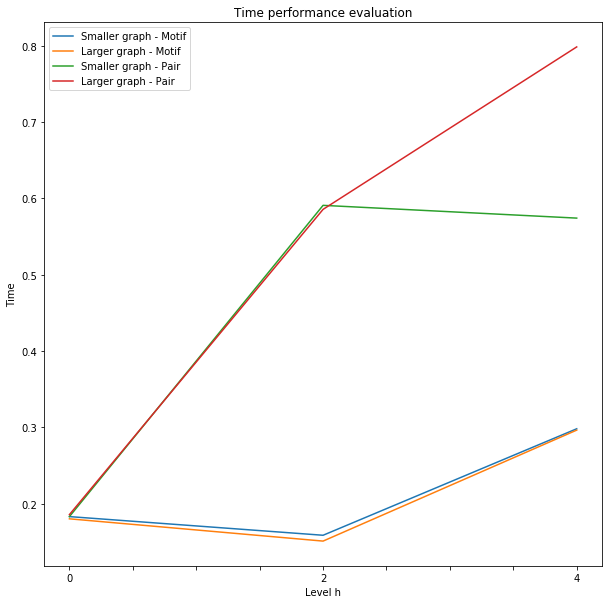

Text(0, 0.5, 'Time')

In [0]:
from matplotlib import pyplot as plt



dfRes = pd.concat([df1,df2]).transpose()

dfRes.plot.line(figsize=(10,10))
plt.title("Time performance evaluation")
plt.xlabel("Level h")
plt.ylabel("Time")


##Provenance Kernels v1.0 vs v2.0 Pair vs 2.0 Motif Runtime Comparison

In [0]:
def run_pk_comparisons(document):
    PK1res = []
    PK2Mres =[]
    PK2Pres = []
    #loop 5 times and find average value
    for i in range(5):
        start = time.perf_counter()
        PKv1(document,2)
        end = time.perf_counter()
        PK1res.append(end - start)

        start = time.perf_counter()
        PKv2Motif(document,2)
        end = time.perf_counter()
        PK2Mres.append(end - start)

        start = time.perf_counter()
        PKv2Pair(document,2)
        end = time.perf_counter()
        PK2Pres.append(end - start)
    pk1time = sum(PK1res)/len(PK1res)
    pk2mtime = sum(PK2Mres)/len(PK2Mres)
    pk2ptime = sum(PK2Pres)/len(PK2Pres)
    plt.bar(["PKv1","PKv2 Motif-finding", "PKv2 Pair-matching"], [pk1time/pk1time,pk2mtime/pk1time, pk2ptime/pk1time])

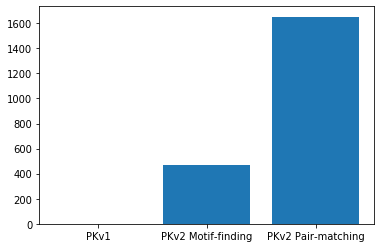

In [0]:
run_pk_comparisons(document)

#NetworkX vs Graphframes

In [0]:
SHORT_NAMES = {
    "prov:Entity": "ent",
    "prov:Activity": "act",
    "prov:Generation": "gen",
    "prov:Usage": "usd",
    "prov:Communication": "wib",
    "prov:Start": "wsb",
    "prov:End": "web",
    "prov:Invalidation": "inv",
    "prov:Derivation": "der",
    "prov:Agent": "agt",
    "prov:Attribution": "att",
    "prov:Association": "waw",
    "prov:Delegation": "del",
    "prov:Influence": "inf",
    "prov:Alternate": "alt",
    "prov:Specialization": "spe",
    "prov:Mention": "men",
    "prov:Membership": "mem",
}
provClassList = [
    "prov:Entity",
    "prov:Activity",
    "prov:Generation",
    "prov:Usage",
    "prov:Communication",
    "prov:Start",
    "prov:End",
    "prov:Invalidation",
    "prov_Derivation",
    "prov:Agent",
    "prov:Attribution",
    "prov:Association",
    "prov:Delegation",
    "prov:Influence",
    "prov:Alternate",
    "prov:Specialization",
    "prov:Mention",
    "prov:Membership",
]

In [0]:
from prov.graph import prov_to_graph
def prov_to_graphframe(prov_document):
        unified = prov_document.unified()
        node_map = {}
        vList = []
        eList = []
        for element in unified.get_records(ProvElement):
          vList.append(((str(element)),str(element.identifier),SHORT_NAMES[str(element.get_type())],str(element.get_asserted_types())))
          node_map[element.identifier] = element

        for relation in unified.get_records(ProvRelation):
                attr_pair_1, attr_pair_2 = relation.formal_attributes[:2]
                qn1, qn2 = attr_pair_1[1], attr_pair_2[1]
                if qn1 and qn2:  
                    try:
                        if qn1 not in node_map:
                            node_map[qn1] = INFERRED_ELEMENT_CLASS[attr_pair_1[0]](None, qn1)
                        if qn2 not in node_map:
                            node_map[qn2] = INFERRED_ELEMENT_CLASS[attr_pair_2[0]](None, qn2)
                    except KeyError:
                        continue  
                    eList.append((str(node_map[qn1].identifier), str(node_map[qn2].identifier), str(relation),SHORT_NAMES[str(relation.get_type())]))
        v = sqlContext.createDataFrame(vList,["element","id","type","primitive type"])
        e = sqlContext.createDataFrame(eList, ["src","dst","relation","relation type"])
        g= GraphFrame(v, e) 
        return g

In [0]:
import time
from matplotlib import pyplot as plt
start = time.perf_counter()
g = prov_to_graph(document)
end = time.perf_counter()
nx_Time = end - start

start = time.perf_counter()
g = prov_to_graphframe(document)
end = time.perf_counter()
gf_Time = end - start
plt.ylabel("Time relative to Network X Conversion function")
plt.bar(["Network X conversion time","Graphframes conversion time"], [nx_Time/nx_Time,gf_Time/nx_Time])